In [2]:
import random

import torch
import torchvision.transforms as T
from torch.utils.data import DataLoader

from loc2vec.dataset import TilesDataset
from loc2vec.model import Loc2VecModel, SoftmaxTripletLoss, Loc2VecTripletLoss
from loc2vec.train import train

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [4]:
from loc2vec.memmap_tiles_dataset import MemmapTilesDataset

dataset = MemmapTilesDataset("tiles/tiles_metadata.csv", "tiles/tiles-dataset.npy", neg_radius_min=10, transform=T.Compose([
    T.ToTensor(),
    T.Normalize([0.8107, 0.8611, 0.7814],
                [0.1215, 0.0828, 0.1320])
]))

In [5]:
train_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4, prefetch_factor=4, persistent_workers=True)

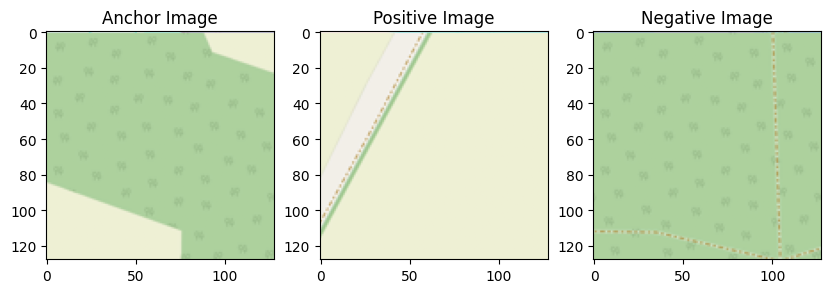

In [6]:
image = next(iter(train_loader))

denormalize = T.Normalize(
    mean=[-0.8107/0.1215, -0.8611/0.0828, -0.7814/0.1320],
    std=[1/0.1215, 1/0.0828, 1/0.1320]
)

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(denormalize(image['anchor_image'][0]).numpy().transpose(1, 2, 0))
plt.title("Anchor Image")

plt.subplot(1, 3, 2)
plt.imshow(denormalize(image['pos_image'][0]).numpy().transpose(1, 2, 0))
plt.title("Positive Image")

plt.subplot(1, 3, 3)
plt.imshow(denormalize(image['neg_image'][0]).numpy().transpose(1, 2, 0))
plt.title("Negative Image")

plt.show()

In [7]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = Loc2VecModel(input_channels=3, embedding_dim=16, dropout_rate=0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_fn = Loc2VecTripletLoss()

sample = random.choice(dataset)

print(f"Input shape: {sample['anchor_image'].shape}")
print(f"Training on device: {device}")

model.to(device)

for epoch in range(5):
    avg_loss = train(model, train_loader, optimizer, loss_fn, device=device)
    print(f"Epoch {epoch + 1}, Average Loss: {avg_loss:.4f}")

Input shape: torch.Size([3, 128, 128])
Training on device: mps


Training: 100%|██████████| 19333/19333 [11:09<00:00, 28.88it/s]


Epoch 1, Average Loss: 0.4033


Training: 100%|██████████| 19333/19333 [11:13<00:00, 28.69it/s]


Epoch 2, Average Loss: 0.3554


Training: 100%|██████████| 19333/19333 [11:28<00:00, 28.08it/s]


Epoch 3, Average Loss: 0.3448


Training: 100%|██████████| 19333/19333 [11:18<00:00, 28.51it/s]


Epoch 4, Average Loss: 0.3388


Training: 100%|██████████| 19333/19333 [11:04<00:00, 29.10it/s]

Epoch 5, Average Loss: 0.3357


In [20]:
from loc2vec.embeddings import log_embeddings_to_tensorboard

log_embeddings_to_tensorboard(model, train_loader, device=device, log_dir="logs/embeddings", max_samples=5000)

Starting embedding extraction, max_samples=5000

--- Batch 0 ---
Batch keys: dict_keys(['anchor_image', 'pos_image', 'neg_image', 'x', 'y', 'zoom'])
anchor_images.shape: torch.Size([32, 3, 128, 128])
batch['x'] length: 32
batch['y'] length: 32
batch['zoom'] length: 32
embeddings.shape: torch.Size([32, 16])
batch_metadata length: 32
sample_count after batch: 32
total metadata length: 32
embeddings_list lengths: [32]
images_list lengths: [32]

--- Batch 1 ---
Batch keys: dict_keys(['anchor_image', 'pos_image', 'neg_image', 'x', 'y', 'zoom'])
anchor_images.shape: torch.Size([32, 3, 128, 128])
batch['x'] length: 32
batch['y'] length: 32
batch['zoom'] length: 32
embeddings.shape: torch.Size([32, 16])
batch_metadata length: 32
sample_count after batch: 64
total metadata length: 64
embeddings_list lengths: [32, 32]
images_list lengths: [32, 32]

--- Batch 2 ---
Batch keys: dict_keys(['anchor_image', 'pos_image', 'neg_image', 'x', 'y', 'zoom'])
anchor_images.shape: torch.Size([32, 3, 128, 128]

In [16]:
torch.save(model.state_dict(), "loc2vec_model_kyiv_region.pth")